In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score, make_scorer

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm


from cleantext import clean

from nlp_id.lemmatizer import Lemmatizer
from nlp_id.stopword import StopWord
from googletrans import Translator
from langdetect import detect
from nlp_id.stopword import StopWord
from nlp_id.lemmatizer import Lemmatizer
from nltk.tokenize import sent_tokenize

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_tbh = pd.read_excel('dataset_turnbackhoax_10k.xlsx')

In [3]:
df_tbh.head()

Title  \
0          [SALAH] Anies Baswedan Dekat Dengan Aliran Krsiten Sesat Alpha Omega di Papua   
1  [SALAH] Hakim Wahyu Iman Santoso Alami Kecelakaan Tunggal Usai Vonis Mati Ferdy Sambo   
2                                          [SALAH] GAMBAR MEGAWATI DAN PUAN BERMAIN SLOT   
3                [SALAH] JONATHAN LATUMAHINA SEORANG NASRANI DAN PENYUSUP DI ORMAS ISLAM   
4                 [SALAH] PESAN WHATSAPP DARI BMKG YANG KABARKAN GUNUNG SINABUNG MELETUS   

           Timestamp  \
0      Maret 1, 2023   
1      Maret 1, 2023   
2  Februari 28, 2023   
3  Februari 28, 2023   
4  Februari 28, 2023   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [4]:
df_tbh['Tags'].value_counts()

Fitnah;Hasut;Hoax    9729
Lain-lain             577
Berita                 76
Events                  2
Name: Tags, dtype: int64

In [5]:
df_tbh['label'] = np.where(df_tbh['Tags'] == 'Fitnah;Hasut;Hoax', 1, 0)

In [6]:
df_cnn = pd.read_excel('dataset_cnn_10k.xlsx')

In [7]:
df_cnn['label'] = 0

In [10]:
train_data = pd.concat([df_tbh, df_cnn], axis=0)

In [11]:
train_data = train_data[['FullText', 'label']]

In [12]:
print(train_data['label'].value_counts())
print(train_data['label'].value_counts(normalize=True)*100)

0    10655
1     9729
Name: label, dtype: int64
0    52.271389
1    47.728611
Name: label, dtype: float64


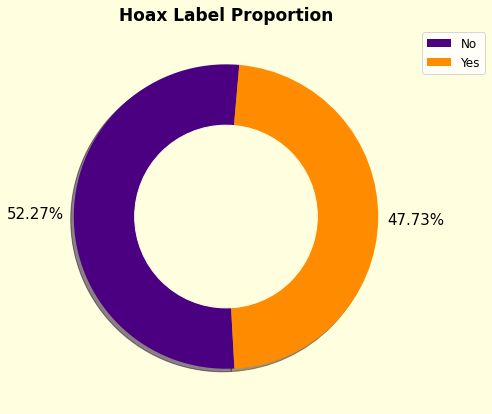

In [13]:
plt.figure(figsize=(8,7), facecolor='lightyellow')
plt.pie(train_data['label'].value_counts(), autopct='%.2f%%', pctdistance = 1.25,startangle=85, textprops={'fontsize': 15},
        colors=['indigo','darkorange'], shadow=True)
my_circle=plt.Circle( (0,0), 0.6, color='lightyellow')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.title('Hoax Label Proportion', fontsize=17, fontweight='bold')
plt.legend(['No', 'Yes'], bbox_to_anchor=(1, 1), fontsize=12)


plt.show()

# Data Pre-Processing

## Lower case

In [14]:
def clean_lower(lwr):
    lwr = lwr.lower() # lowercase text
    return lwr


train_data['text_lower'] = train_data['FullText'].astype(str).apply(clean_lower)

In [15]:
train_data.head()

FullText  \
0  Hasil Periksa Fakta Gabriela Nauli Sinaga (Universitas Sumatera Utara)\nFaktanya, komunitas Alpha Omega yang menyambut Anies Baswedan di Papua bukan Alpha Omega yang merupakan aliran Kristen sesat. Diketahui ternyata banyak nama komunitas Alpha Omega tersebar di Papua dan tidak semuanya merupakan komunitas atau aliran sesat.\nSelengkapnya ada di penjelasan.\n=====\n[KATEGORI]: MISLEADING CONTENT/Konten Menyesatkan\n======\n[SUMBER]: TWITTER\nhttps://archive.vn/sGF6V\nhttps://twitter.com/CindyEeemilia/status/1628404789456560134?s=20\nhttps://www.katalogika.com/info-logika/pr-1446262285/anies-akui-dekat-dengan-aliran-sesat-kristen-alfa-omega-papua\n\n=====\n[NARASI]:\n“BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU APA YANG PENTING DAPAT SUARA SEGALA CARA DEMI KEKUASAAN”\n=====\n[PENJELASAN]:\nSebuah unggahan di media sosial Twitter menampilkan hasil tangkapan layar dari artikel berita yang berjudul, “Anies Akui Dekat Dengan Aliran Sesat Kristen Alfa Omega Papua”. Unggahan oleh akun @ ini juga menambahkan sebuah narasi yang menyatakan bahwa Anies melakukan segala cara demi sebuah kekuasaan.\n“BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU APA YANG PENTING DAPAT SUARA SEGALA CARA DEMI KEKUASAAN”\nNamun setelah menelusuri terkait dengan kebenaran berita ini, ditemukan sebuah fakta yang dapat menunjukkan bahwa klaim ini merupakan sebuah klaim yang keliru. Pasalnya, terdapat kekeliruan terhadap nama Alpha Omega yang dimaksud di dalam artikel, dengan Alpha Omega tempat Anies Baswedan melakukan kunjungan pada 2022 lalu.\nHasil tangkapan layar pada akun Twitter ini merupakan hasil tangkapan layar dari artikel milik media online katalogika.com yang berjudul, ““Anies Akui Dekat Dengan Aliran Sesat Kristen Alfa Omega Papua”. Artikel ini diketahui telah beredar pada bulan Desember tahun 2022 lalu. Di dalamnya, artikel ini mengungkapkan sebuah klaim yang menyatakan bahwa Anies mengakui dekat dengan sebuah aliran sesat di Alpha Omega di Kabupaten Supiori, Kota Sentani Papua dan diberi nama Yohanes oleh Ondofolo (sebutan Imam di Alfa Omega).\nKlaim oleh artikel ini muncul berdasarkan pernyataan dari Ade Armando pada video di sebuah unggahan akun Youtube Channel Cokro TV yang tayang pada 26 Desember 2022. Dalam video tersebut Ade Armando menyatakan bahwa komunitas Kristen Alpha Omega merupakan aliran Kristen sesat. Mereka berdoa di atas batu yang dipercaya tempat persemayaman Tuhan. Mereka percaya, hubungan badan bukan pasangan suami istri akan meningkatkan ketaqwaan. Pernyataan kemudian menjadi dasar dari timbulnya klaim bahwa Anies Baswedan menerima nama dan dekat dengan aliran Kristen sesat bernama Alpha Omega.\nNamun ternyata, selang beberapa hari sejak video dari Ade Armando ini tayang, akun Youtube Channel Cokro TV kemudian mengeluarkan video baru yang diketahui merupakan video klarifikasi dari video sebelumnya. Dalam tayangan yang berjudul ALFA OMEGA YANG MENERIMA ANIES BUKAN ORGANISASI YANG MENYESATKAN, Ade Armando menegaskan Alfa Omega yang menerima kunjungan Anies bukan gereja yang memiliki aliran sesat. Dirinya menyatakan bahwa belakangan dia mengetahui bahwa kedua gereja itu berbeda dan hanya memiliki nama yang sama setelah diberi tahu sutradara Angga Dwimas Sasongko, yang merupakan keponakan pemimpin Gereja Alfa Omega di Jayapura, Pendeta Robert Nerotumilena.\n“Kesalahan saya adalah mengira bahwa kedua gereja tersebut adalah dua gereja yang sama. Sekarang saya memperoleh informasi lagi bahwa itu adalah dua gereja yang berbeda namanya sama-sama Alfa Omega tapi gereja yang berbeda,” kata Ade Armando di kanal Youtube @CokroTv.\nDi dalam video tersebut Ade Armando menegaskan bahwa Alfa Omega yang menerima kunjungan Anies bukan gereja yang memiliki aliran sesat.\n“Jadi sekarang mudah-mudahan menjadi jelas Alfa Omega yang menerima Anies adalah Alfa Omega yang dipimpin pendeta Robert Nerotumilena yang tidak dianggap sesat,” ungkapnya.\n“Saya harus minta maaf kepada Pendeta Robert yang mungkin sudah terganggu nama baiknya akibat 

## Remove Punctuation

In [16]:
clean_spcl = re.compile('[/(){}\[\]\|@,;]')
clean_symbol = re.compile('[^0-9a-z]')

def clean_punct(text):
    text = clean_spcl.sub('', text)
    text = clean_symbol.sub(' ', text)
    # Removing html tags
    text = re.sub('<[^>]*>', '', text)
    # Removing emails
    text = re.sub('\S*@\S*\s?', '', text)
    # Removing urls
    text = re.sub('https?://[A-Za-z0-9]','',text)
    # Removing emoji
    text = clean(text, no_emoji=True)
    return text


# Buat kolom tambahan untuk data description yang telah diremovepunctuation   
train_data['clean_punct'] = train_data['text_lower'].apply(clean_punct)

In [17]:
train_data.head()

FullText  \
0  Hasil Periksa Fakta Gabriela Nauli Sinaga (Universitas Sumatera Utara)\nFaktanya, komunitas Alpha Omega yang menyambut Anies Baswedan di Papua bukan Alpha Omega yang merupakan aliran Kristen sesat. Diketahui ternyata banyak nama komunitas Alpha Omega tersebar di Papua dan tidak semuanya merupakan komunitas atau aliran sesat.\nSelengkapnya ada di penjelasan.\n=====\n[KATEGORI]: MISLEADING CONTENT/Konten Menyesatkan\n======\n[SUMBER]: TWITTER\nhttps://archive.vn/sGF6V\nhttps://twitter.com/CindyEeemilia/status/1628404789456560134?s=20\nhttps://www.katalogika.com/info-logika/pr-1446262285/anies-akui-dekat-dengan-aliran-sesat-kristen-alfa-omega-papua\n\n=====\n[NARASI]:\n“BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU APA YANG PENTING DAPAT SUARA SEGALA CARA DEMI KEKUASAAN”\n=====\n[PENJELASAN]:\nSebuah unggahan di media sosial Twitter menampilkan hasil tangkapan layar dari artikel berita yang berjudul, “Anies Akui Dekat Dengan Aliran Sesat Kristen Alfa Omega Papua”. Unggahan oleh akun @ ini juga menambahkan sebuah narasi yang menyatakan bahwa Anies melakukan segala cara demi sebuah kekuasaan.\n“BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU APA YANG PENTING DAPAT SUARA SEGALA CARA DEMI KEKUASAAN”\nNamun setelah menelusuri terkait dengan kebenaran berita ini, ditemukan sebuah fakta yang dapat menunjukkan bahwa klaim ini merupakan sebuah klaim yang keliru. Pasalnya, terdapat kekeliruan terhadap nama Alpha Omega yang dimaksud di dalam artikel, dengan Alpha Omega tempat Anies Baswedan melakukan kunjungan pada 2022 lalu.\nHasil tangkapan layar pada akun Twitter ini merupakan hasil tangkapan layar dari artikel milik media online katalogika.com yang berjudul, ““Anies Akui Dekat Dengan Aliran Sesat Kristen Alfa Omega Papua”. Artikel ini diketahui telah beredar pada bulan Desember tahun 2022 lalu. Di dalamnya, artikel ini mengungkapkan sebuah klaim yang menyatakan bahwa Anies mengakui dekat dengan sebuah aliran sesat di Alpha Omega di Kabupaten Supiori, Kota Sentani Papua dan diberi nama Yohanes oleh Ondofolo (sebutan Imam di Alfa Omega).\nKlaim oleh artikel ini muncul berdasarkan pernyataan dari Ade Armando pada video di sebuah unggahan akun Youtube Channel Cokro TV yang tayang pada 26 Desember 2022. Dalam video tersebut Ade Armando menyatakan bahwa komunitas Kristen Alpha Omega merupakan aliran Kristen sesat. Mereka berdoa di atas batu yang dipercaya tempat persemayaman Tuhan. Mereka percaya, hubungan badan bukan pasangan suami istri akan meningkatkan ketaqwaan. Pernyataan kemudian menjadi dasar dari timbulnya klaim bahwa Anies Baswedan menerima nama dan dekat dengan aliran Kristen sesat bernama Alpha Omega.\nNamun ternyata, selang beberapa hari sejak video dari Ade Armando ini tayang, akun Youtube Channel Cokro TV kemudian mengeluarkan video baru yang diketahui merupakan video klarifikasi dari video sebelumnya. Dalam tayangan yang berjudul ALFA OMEGA YANG MENERIMA ANIES BUKAN ORGANISASI YANG MENYESATKAN, Ade Armando menegaskan Alfa Omega yang menerima kunjungan Anies bukan gereja yang memiliki aliran sesat. Dirinya menyatakan bahwa belakangan dia mengetahui bahwa kedua gereja itu berbeda dan hanya memiliki nama yang sama setelah diberi tahu sutradara Angga Dwimas Sasongko, yang merupakan keponakan pemimpin Gereja Alfa Omega di Jayapura, Pendeta Robert Nerotumilena.\n“Kesalahan saya adalah mengira bahwa kedua gereja tersebut adalah dua gereja yang sama. Sekarang saya memperoleh informasi lagi bahwa itu adalah dua gereja yang berbeda namanya sama-sama Alfa Omega tapi gereja yang berbeda,” kata Ade Armando di kanal Youtube @CokroTv.\nDi dalam video tersebut Ade Armando menegaskan bahwa Alfa Omega yang menerima kunjungan Anies bukan gereja yang memiliki aliran sesat.\n“Jadi sekarang mudah-mudahan menjadi jelas Alfa Omega yang menerima Anies adalah Alfa Omega yang dipimpin pendeta Robert Nerotumilena yang tidak dianggap sesat,” ungkapnya.\n“Saya harus minta maaf kepada Pendeta Robert yang mungkin sudah terganggu nama baiknya akibat 

## Remove double whitespace

In [18]:
def _normalize_whitespace(text):
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")

train_data['clean_double_ws'] = train_data['clean_punct'].apply(_normalize_whitespace)

## Detecting languages on article. Only take Indonesia

In [19]:
def language_detect(text):
    text = detect(text)
    return text

In [20]:
train_data['language'] = train_data['clean_double_ws'].apply(language_detect)

In [21]:
train_data['language'].value_counts()

id    19785
tl      372
en      213
da       12
nl        1
af        1
Name: language, dtype: int64

In [22]:
train_data = train_data[(train_data['language'] == 'id')]

## Lemmatization

In [23]:
lemmatizer = Lemmatizer() 
def lemmatization(text):
    text = lemmatizer.lemmatize(text)
    return text

In [24]:
train_data['lemmatization'] = train_data['clean_double_ws'].apply(lemmatization)

## Stopwords

In [25]:
stopword = StopWord() 
stopword.get_stopword() 

['ada',
 'adalagi',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agak-agak',
 'agaknya',
 'agar',
 'aja',
 'akan',
 'akankah',
 'akankan',
 'akhir',
 'akhir-akhirnya',
 'akhirannya',
 'akhiri',
 'akhirinya',
 'akhirnya',
 'aku',
 'akulah',
 'akunya',
 'akurat',
 'akutu',
 'ala',
 'alamak',
 'alhamdulillah',
 'alhasil',
 'amat',
 'amat-amat',
 'amatlah',
 'anda',
 'anda-anda',
 'andai',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apa-apanya',
 'apaan',
 'apabila',
 'apaitu',
 'apakah',
 'apalagi',
 'apanya',
 'apasaja',
 'apatah',
 'apesnya',
 'arah',
 'artinya',
 'asal',
 'asalkan',
 'asumsinya',
 'asumsikan',
 'atas',
 'atas-atas',
 'atas-batas',
 'ataspun',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagi-bagi',
 'bagian',
 'bagikan',
 'bahasakan',
 'bahasanya',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bak',
 'bakal',
 'bakal-bakal',
 'bakalan',
 'balik',
 'balikan',
 'balikk

In [26]:
stopword = StopWord() 
def stopword_id(text):
    text = stopword.remove_stopword(text)
    return text

In [27]:
train_data['stopword'] = train_data['lemmatization'].apply(stopword_id)

# Data Split

In [75]:
data_y = train_data['label']

In [76]:
x_train, x_test, y_train, y_test = train_test_split(train_data['stopword'], data_y, test_size=0.3, random_state=77)

In [77]:
print('x_train : ', len(x_train))
print('x_test : ', len(x_test))

x_train :  13849
x_test :  5936


In [78]:
Encoder = LabelEncoder()
ohe_enc = Encoder.fit(y_train)
y_train = ohe_enc.transform(y_train)
y_test = ohe_enc.transform(y_test)

# Load word2vec

In [79]:
from gensim.models import KeyedVectors
filename = 'glove.6B.100d.txt.word2vec'
w2v_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [80]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model[word] for word in words if word in w2v_model]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

x_train = np.array([vectorize(sentence) for sentence in x_train])
x_test = np.array([vectorize(sentence) for sentence in x_test])

# Modeling

In [81]:
mlp = MLPClassifier(max_iter=120, random_state=5, hidden_layer_sizes=(110, 30), activation='tanh', learning_rate='adaptive')
mlp.fit(x_train, y_train)

predictionmlp_test = mlp.predict(x_test)
print(confusion_matrix(y_test, predictionmlp_test))
print("Akurasi dari Multilayer Perceptron adalah:", (accuracy_score(y_test, predictionmlp_test)*100) )
print("Recall dari Multilayer Perceptron adalah:",recall_score(y_test, predictionmlp_test)*100)
print("Precision dari Multilayer Perceptron adalah:",precision_score(y_test, predictionmlp_test)*100)
print("F1 dari Multilayer Perceptron adalah:",f1_score(y_test, predictionmlp_test)*100)

[[2886  224]
 [ 121 2705]]
Akurasi dari Multilayer Perceptron adalah: 94.18800539083558
Recall dari Multilayer Perceptron adalah: 95.71832979476291
Precision dari Multilayer Perceptron adalah: 92.35233868214408
F1 dari Multilayer Perceptron adalah: 94.00521285838401


In [35]:
predictionmlp_train = mlp.predict(x_train)
print(confusion_matrix(y_train, predictionmlp_train))
print("Akurasi Training dari Multilayer Perceptron adalah:", (accuracy_score(y_train, predictionmlp_train)*100) )
print("Recall Training dari Multilayer Perceptron adalah:",recall_score(y_train, predictionmlp_train)*100)
print("Precision Training dari Multilayer Perceptron adalah:",precision_score(y_train, predictionmlp_train)*100)
print("F1 Training dari Multilayer Perceptron adalah:",f1_score(y_train, predictionmlp_train)*100)

[[6787  380]
 [ 123 6559]]
Akurasi Training dari Multilayer Perceptron adalah: 96.36796880641202
Recall Training dari Multilayer Perceptron adalah: 98.1592337623466
Precision Training dari Multilayer Perceptron adalah: 94.5237065859634
F1 Training dari Multilayer Perceptron adalah: 96.3071727479627


In [36]:
prediction_test = mlp.predict(x_test)
prediction_train = mlp.predict(x_train)
training_acc = accuracy_score(y_train, prediction_train)
testing_acc = accuracy_score(y_test, prediction_test)

print("Training Accuracy: {}".format(training_acc))
print("Testing Accuracy: {}".format(testing_acc))
print(classification_report(y_test, prediction_test))

Training Accuracy: 0.9636796880641202
Testing Accuracy: 0.9418800539083558
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      3110
           1       0.92      0.96      0.94      2826

    accuracy                           0.94      5936
   macro avg       0.94      0.94      0.94      5936
weighted avg       0.94      0.94      0.94      5936



In [37]:
prediction_test = mlp.predict(x_test)
prediction_train = mlp.predict(x_train)
training_acc = accuracy_score(y_train, prediction_train)
testing_acc = accuracy_score(y_test, prediction_test)

print("Training Accuracy: {}".format(training_acc))
print("Testing Accuracy: {}".format(testing_acc))
print(classification_report(y_train, prediction_train))

Training Accuracy: 0.9636796880641202
Testing Accuracy: 0.9418800539083558
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      7167
           1       0.95      0.98      0.96      6682

    accuracy                           0.96     13849
   macro avg       0.96      0.96      0.96     13849
weighted avg       0.96      0.96      0.96     13849



In [82]:
import joblib
import pickle
from sklearn.pipeline import Pipeline

In [83]:
pipeline = Pipeline(steps=[('classifier', MLPClassifier(max_iter=120, random_state=5, hidden_layer_sizes=(110, 30), activation='tanh', learning_rate='adaptive'))])

In [84]:
pipeline = pipeline.fit(x_train, y_train)
filename = 'trained_model_hoax.pkl'
joblib.dump(pipeline, filename)

['trained_model_hoax.pkl']

# Analysis

In [43]:
x_train, x_test, y_train, y_test = train_test_split(train_data['stopword'], data_y, test_size=0.3, random_state=77)

In [44]:
train_words = pd.DataFrame(x_train.tolist(), columns=['word'])
words_train = {
    x for x in ' '.join(
        train_words.word.tolist()
    ).split() if x.isalpha()
}

In [45]:
test_words = pd.DataFrame(x_test.tolist(), columns=['word'])
words_test = {
    x for x in ' '.join(
        test_words.word.tolist()
    ).split() if x.isalpha()
}

In [42]:
word_no_test = []
for i in words_train:
    if i not in words_test:
        word_no_test.append(i)

In [89]:
len(word_no_test)

65374

In [90]:
word_no_test

['invention',
 'lautandhana',
 'fouxzcr',
 'yayasantempat',
 'netsosokmau',
 'lelanginternaldotcom',
 'kinos',
 'pmasukan',
 'officialsunnahreminders',
 'dhanny',
 'simultaneous',
 'attorneys',
 'najar',
 'hasannudin',
 'benchmarking',
 'bpkpresiden',
 'dprdsurvei',
 'saikhu',
 'infobencanabnpbtiktok',
 'fifiy',
 'pilonpara',
 'fotbyxs',
 'herdian',
 'bumm',
 'isnanta',
 'tanggulangin',
 'rahulrajnews',
 'dprdprddpd',
 'harisstiawan',
 'comrisma',
 'jebstsundamba',
 'badaukabupaten',
 'karcis',
 'utangsebelumnya',
 'pacgpansorbenjeng',
 'pppade',
 'prasetiokemudian',
 'sembul',
 'kewenangandia',
 'pramonoanungw',
 'hoslabdengan',
 'periodesecara',
 'perekonnomian',
 'bawasludia',
 'kathmandupost',
 'jjpnews',
 'peroranganpermenkes',
 'avas',
 'ditukarhttps',
 'casr',
 'pante',
 'fakhrizal',
 'tcp',
 'sapioper',
 'nbt',
 'atv',
 'vaughn',
 'aprilpolisi',
 'frdmtsarh',
 'kelaparania',
 'keterlib',
 'ratoh',
 'projektil',
 'recordsitubondo',
 'faria',
 'kabinetpada',
 'imunusasi',
 'prokl

In [91]:
word_no_train = []
for i in words_test:
    if i not in words_train:
        word_no_train.append(i)

In [92]:
len(word_no_train)

25116

In [93]:
word_no_train

['phvjlvl',
 'ctsr',
 'jamhttps',
 'beautyremedies',
 'medicaldaily',
 'lazismu',
 'stadia',
 'indovasi',
 'comasrimaliki',
 'converging',
 'umrohkirim',
 'saturnino',
 'baratpaulus',
 'nansp',
 'pum',
 'mmbuat',
 'orangsaleh',
 'yanginlari',
 'himasal',
 'orissapost',
 'gatotmulyanto',
 'baruruu',
 'gik',
 'vnmrvjg',
 'comrd',
 'alsurpres',
 'musaveni',
 'siapacepatdiahemat',
 'comopinionsfda',
 'minghttps',
 'kbkb',
 'peogram',
 'ppsk',
 'kunjir',
 'qodar',
 'pengawalanhttps',
 'mdi',
 'ddi',
 'malesiya',
 'pitalokaanggota',
 'sarekat',
 'matematikakemudian',
 'comfaisal',
 'berternak',
 'sitik',
 'dikendaraihanya',
 'pezza',
 'gofundme',
 'greeenwald',
 'arimunandar',
 'foypcxe',
 'astonished',
 'tiwery',
 'kreatelymedia',
 'walini',
 'adress',
 'comakar',
 'bulelenb',
 'permutasi',
 'bungbuanno',
 'sessionid',
 'sodrun',
 'arira',
 'tjiptomangunkusumo',
 'kesusumerespons',
 'providers',
 'sykur',
 'bargibanti',
 'diripolisi',
 'infov',
 'substantial',
 'mdsbviv',
 'pdpde',
 'jabe',

In [46]:
from collections import Counter

# split() returns list of all the words in the string
split_it = str(x_test).split()

# Pass the split_it list to instance of Counter class.
Counters_found = Counter(split_it)
#print(Counters)

# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counters_found.most_common(10)
df_test_occ = pd.DataFrame(most_occur, columns=['word', 'count'])
print(most_occur)

[('data', 25), ('anies', 21), ('artikel', 20), ('nyata', 19), ('pasien', 18), ('rst', 17), ('sunny', 16), ('ambon', 16), ('video', 15), ('calon', 15)]


In [47]:
from collections import Counter

# split() returns list of all the words in the string
split_it = str(x_train).split()

# Pass the split_it list to instance of Counter class.
Counters_found = Counter(split_it)
#print(Counters)

# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counters_found.most_common(10)
df_train_occ = pd.DataFrame(most_occur, columns=['word', 'count'])
print(most_occur)

[('video', 37), ('jakarta', 32), ('the', 32), ('saudi', 22), ('resmi', 20), ('of', 19), ('lihat', 18), ('orang', 18), ('papua', 18), ('to', 17)]


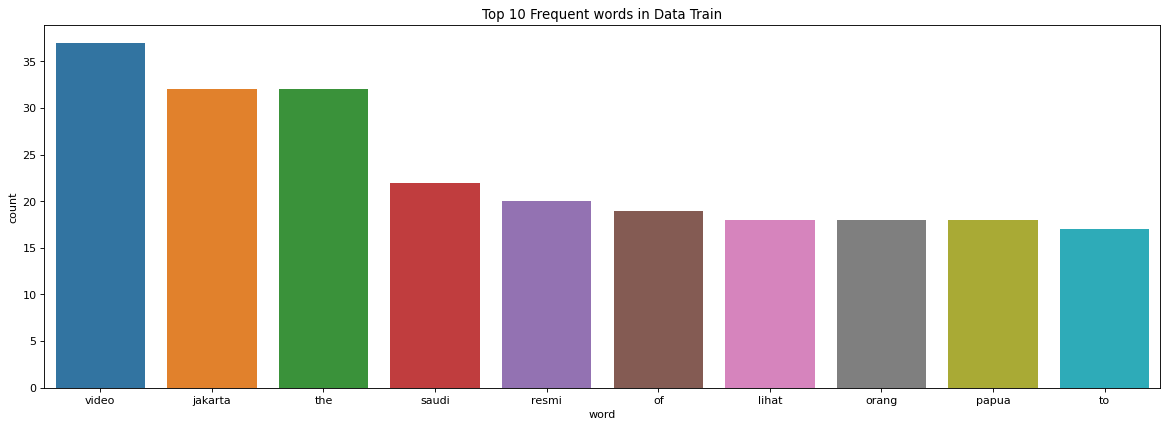

In [48]:
plt.figure(figsize=(18, 6), dpi=80)
sns.barplot(data = df_train_occ, x = 'word', y = 'count')
plt.title('Top 10 Frequent words in Data Train')

plt.show()

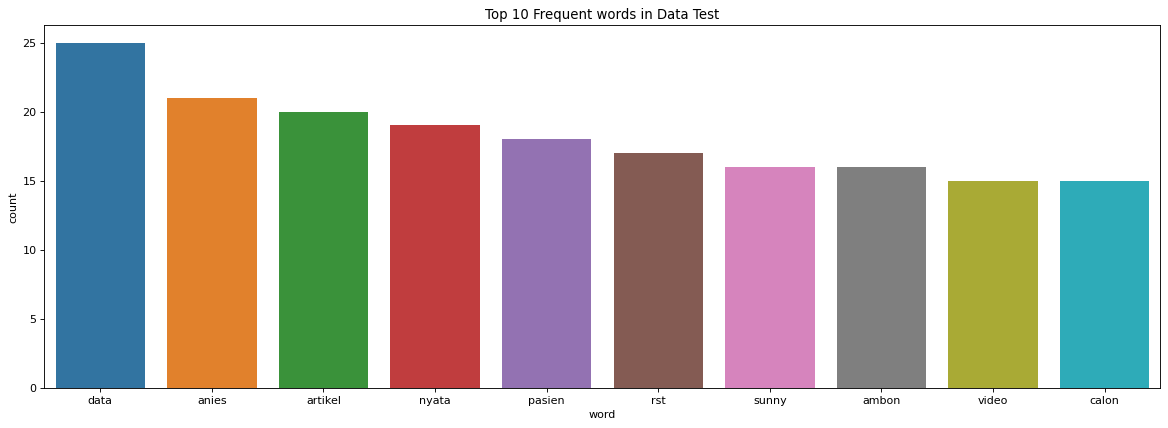

In [49]:
plt.figure(figsize=(18, 6), dpi=80)
sns.barplot(data = df_test_occ, x = 'word', y = 'count')
plt.title('Top 10 Frequent words in Data Test')

plt.show()

In [50]:
df_xtest = pd.DataFrame(x_test)
df_ytest = pd.DataFrame(y_test)
df_ypred = pd.DataFrame(prediction_test, columns=['prediction'])

In [241]:
df_ypred.shape

(5935, 1)

In [51]:
test_result = pd.concat([df_xtest, df_ytest], axis=1, ignore_index=True).reset_index()
test_result = pd.concat([test_result, df_ypred], axis=1, ignore_index=True)
test_result = test_result.rename(columns={1:'words', 2:'label', 3:'prediction'}).drop(0, axis=1)

In [52]:
df_fp = test_result[(test_result['label'] == 0) & (test_result['prediction'] == 1)]

In [53]:
df_fn = test_result[(test_result['label'] == 1) & (test_result['prediction'] == 0)]

In [54]:
df_tp = test_result[(test_result['label'] == 1) & (test_result['prediction'] == 1)]

In [55]:
df_tn = test_result[(test_result['label'] == 0) & (test_result['prediction'] == 0)]

In [56]:
from collections import Counter

# split() returns list of all the words in the string
split_it = str(df_fp['words']).split()

# Pass the split_it list to instance of Counter class.
Counters_found = Counter(split_it)
#print(Counters)

# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counters_found.most_common(10)
occ_fp_test = pd.DataFrame(most_occur, columns=['word', 'count'])
print(most_occur)

[('indonesia', 77), ('ptfi', 64), ('freeport', 48), ('laku', 47), ('masyarakat', 39), ('papua', 38), ('usaha', 32), ('haji', 29), ('data', 26), ('tambang', 24)]


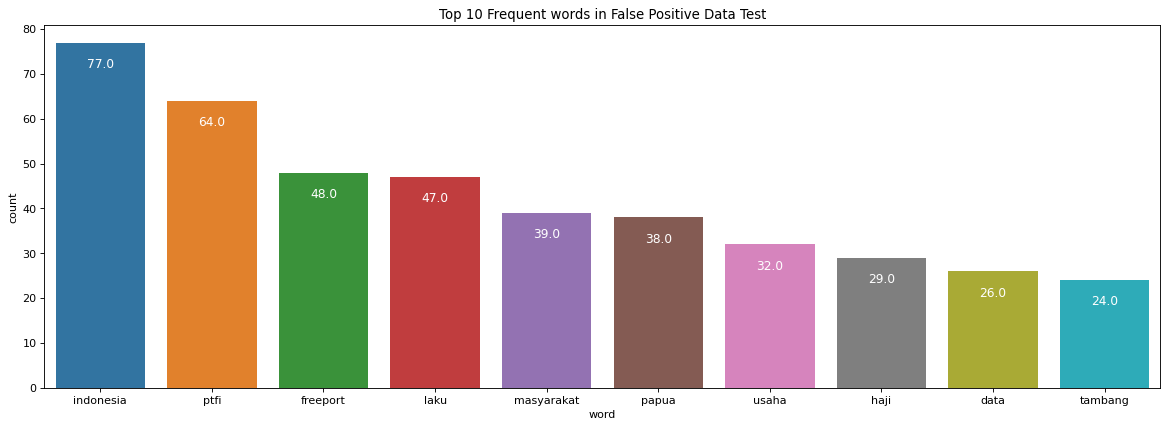

In [57]:
plt.figure(figsize=(18, 6), dpi=80)
ax = sns.barplot(data = occ_fp_test, x = 'word', y = 'count')
plt.title('Top 10 Frequent words in False Positive Data Test')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=11)

plt.show()

In [59]:
from collections import Counter

# split() returns list of all the words in the string
split_it = str(df_fn['words']).split()

# Pass the split_it list to instance of Counter class.
Counters_found = Counter(split_it)
#print(Counters)

# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counters_found.most_common(10)
occ_fn_test = pd.DataFrame(most_occur, columns=['word', 'count'])
print(most_occur)

[('prabowo', 50), ('dki', 50), ('jakarta', 49), ('tangkap', 44), ('dukung', 44), ('kota', 41), ('nama', 41), ('nu', 40), ('perintah', 39), ('tka', 39)]


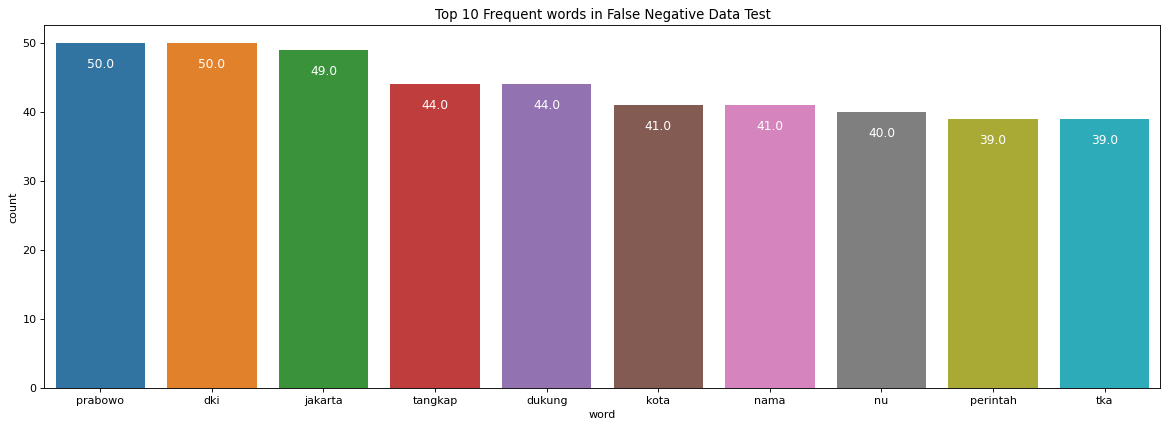

In [68]:
plt.figure(figsize=(18, 6), dpi=80)
ax = sns.barplot(data = occ_fn_test, x = 'word', y = 'count')
plt.title('Top 10 Frequent words in False Negative Data Test')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=11)

plt.show()

In [61]:
from collections import Counter

# split() returns list of all the words in the string
split_it = str(df_tp['words']).split()

# Pass the split_it list to instance of Counter class.
Counters_found = Counter(split_it)
#print(Counters)

# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counters_found.most_common(10)
occ_tp_test = pd.DataFrame(most_occur, columns=['word', 'count'])
print(most_occur)

[('akun', 27), ('artikel', 24), ('foto', 23), ('facebook', 22), ('narasi', 20), ('salah', 19), ('19', 19), ('sumber', 18), ('hasil', 18), ('pasien', 18)]


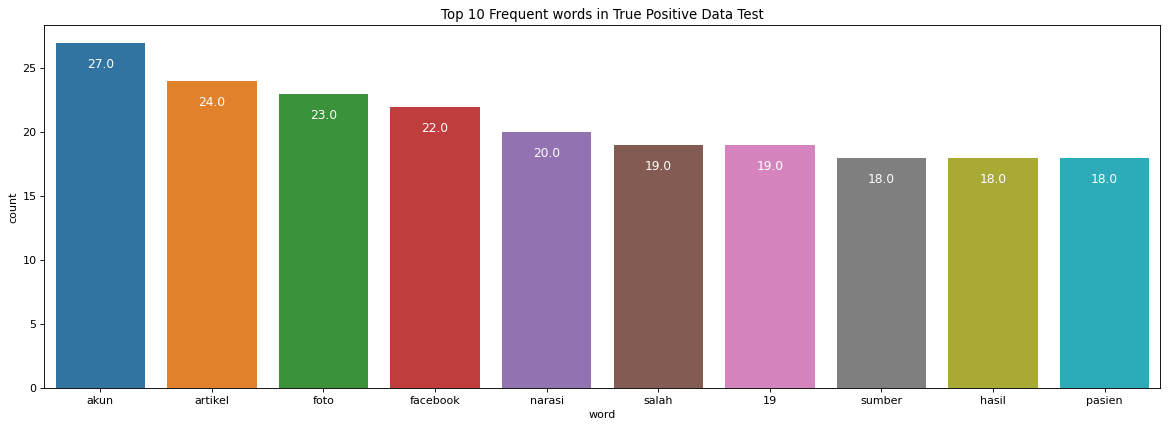

In [67]:
plt.figure(figsize=(18, 6), dpi=80)
ax = sns.barplot(data = occ_tp_test, x = 'word', y = 'count')
plt.title('Top 10 Frequent words in True Positive Data Test')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=11)

plt.show()

In [64]:
from collections import Counter

# split() returns list of all the words in the string
split_it = str(df_tn['words']).split()

# Pass the split_it list to instance of Counter class.
Counters_found = Counter(split_it)
#print(Counters)

# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counters_found.most_common(10)
occ_tn_test = pd.DataFrame(most_occur, columns=['word', 'count'])
print(most_occur)

[('milu', 36), ('anies', 34), ('partai', 33), ('2024', 31), ('jakarta', 26), ('lihat', 24), ('calon', 23), ('tak', 23), ('cnn', 21), ('dpr', 19)]


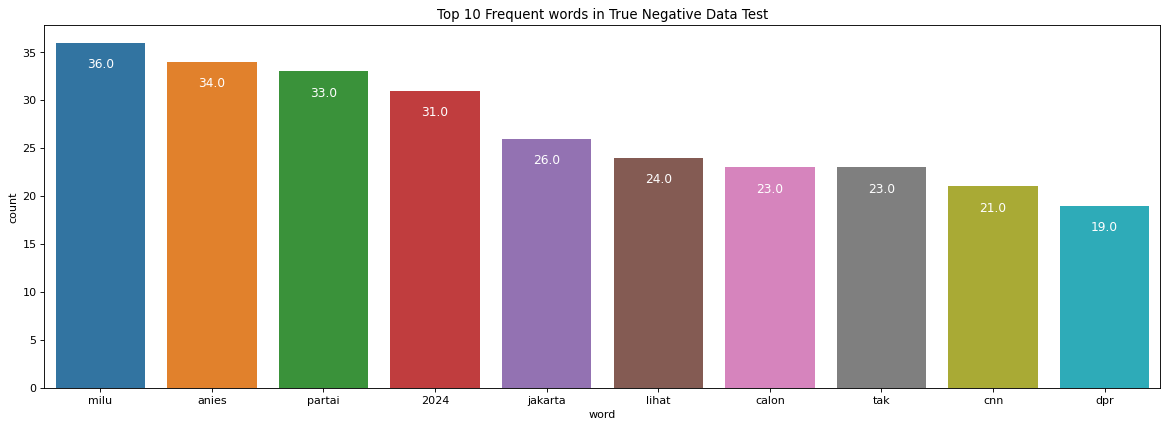

In [66]:
plt.figure(figsize=(18, 6), dpi=80)
ax = sns.barplot(data = occ_tn_test, x = 'word', y = 'count')
plt.title('Top 10 Frequent words in True Negative Data Test')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=11)

plt.show()